# Load raw data

In [13]:
import pandas as pd

file_name = 'train2'
df = pd.read_csv(f'../data/raw/{file_name}.csv')
print(df.head())

                                            promoter  mrna_level
0  TTTTAATTGCAAATTTAGGAATTTTTTTATAAACAAAAAAAAAATT...    5.075236
1  TCAGCTCATCAAACTTACCGGGAACCACTTCGACTCCAAGTTTGAA...    1.311032
2  GGTAGAAGGTGATAGGAATAGGCAAGCCTCACCATATTATATAAAT...    4.430936
3  CTGAGGAAGAAAACGAAATCGAGTTAGTAGAAAATGAGCAGATTCA...    0.476234
4  GATATGAACATCCTACTTAAAAATCTTAATGAACTCCAGGATGGCT...    0.104360


# Compute GC-content, k-mer counts, average length of single nucleotide repeats

In [ ]:
# GC content
df["GC_percentage"] = df["promoter"].str.count("G|C") / 1000

# k-mer counts (1,2,3-mers)
nucleotides = ['A', 'T', 'C', 'G']
dinucleotides = [a+b for a in 'ATCG' for b in 'ATCG']
trinucleotides = [a+b+c for a in 'ATCG' for b in 'ATCG' for c in 'ATCG']

kmer_counts = df["promoter"].apply(
    lambda seq: pd.Series({f'count_{kmer}': seq.count(kmer) for kmer in nucleotides+dinucleotides+trinucleotides})
)
df = pd.concat([df, kmer_counts], axis=1)

# Average length of single nucleotide repeats
def avg_repeat_len(seq, nucleotide):
    subseqs_without_nt = [s for s in seq.split(nucleotide) if s]
    # if the sequence starts or ends with the nucleotide, we have extra repeats which didnt give more splits
    num_of_repeats = len(subseqs_without_nt) - 1 + len([nt for nt in [seq[0],seq[-1]] if nt == nucleotide])
    sum_lens_between_repeats = sum(len(s) for s in subseqs_without_nt)

    return (len(seq) - sum_lens_between_repeats) / num_of_repeats if num_of_repeats > 0 else 0

for nucleotide in 'ATGC':
    df[f"avg_{nucleotide}_repeat_len"] = df["promoter"].apply(lambda seq: avg_repeat_len(seq, nucleotide))

# TODO: add entropy features

# Print some results
print(df[["promoter", "GC_percentage", "avg_A_repeat_len", "avg_T_repeat_len", "avg_G_repeat_len", "avg_C_repeat_len"]].head())


                                            promoter  GC_percentage  \
0  TTTTAATTGCAAATTTAGGAATTTTTTTATAAACAAAAAAAAAATT...          0.315   
1  TCAGCTCATCAAACTTACCGGGAACCACTTCGACTCCAAGTTTGAA...          0.310   
2  GGTAGAAGGTGATAGGAATAGGCAAGCCTCACCATATTATATAAAT...          0.375   
3  CTGAGGAAGAAAACGAAATCGAGTTAGTAGAAAATGAGCAGATTCA...          0.346   
4  GATATGAACATCCTACTTAAAAATCTTAATGAACTCCAGGATGGCT...          0.308   

   avg_A_repeat_len  avg_T_repeat_len  avg_G_repeat_len  avg_C_repeat_len  
0          1.676856          1.662983          1.208333          1.214286  
1          1.454545          1.953271          1.171429          1.214286  
2          1.603015          1.690608          1.333333          1.251969  
3          1.544554          1.540541          1.240000          1.240310  
4          1.466321          1.893519          1.200000          1.161765  


In [15]:
# test avg repeat_len function
print(avg_repeat_len("AAATTTCAAACCGGGAAA", "A")) # Expected output: 3.0
print(avg_repeat_len("TTTCTCCCGGGAAAAA", "A")) # Expected output: 5.0
print(avg_repeat_len("CCCCGGGGTTTT", "A")) # Expected output: 0.0
print(avg_repeat_len("ATATAGGGAACAATAAT", "A")) # Expected output: 1.5
print(avg_repeat_len("AAAAATTGAA", "A")) # Expected output: 3.5

3.0
5.0
0
1.5
3.5


# Compute features for smaller windows

In [ ]:
win_size = 100
step = 50
last_start = len(df.loc[0, 'promoter']) - win_size
sliding_windows = [[start, start + win_size] for start in range(0, last_start+1, step)]
distal_proximal_core_windows = [[0,500],[500,800],[800,1000]]

for (start,end) in sliding_windows + distal_proximal_core_windows:
    window = df['promoter'].str[start:end]

    # GC content
    df[f"GC_percentage_{start}_{end}"] = window.str.count("G|C") / win_size

    # k-mer counts (1,2,3-mers)
    kmer_counts = window.apply(
        lambda seq: pd.Series({f'count_{kmer}_{start}_{end}': seq.count(kmer) for kmer in nucleotides+dinucleotides+trinucleotides})
    )
    df = pd.concat([df, kmer_counts], axis=1)

    # Average length of single nucleotide repeats
    for nucleotide in 'ATGC':
        df[f"avg_{nucleotide}_repeat_len_{start}_{end}"] = window.apply(lambda seq: avg_repeat_len(seq, nucleotide))


    # TODO: add entropy features

# Plot some results

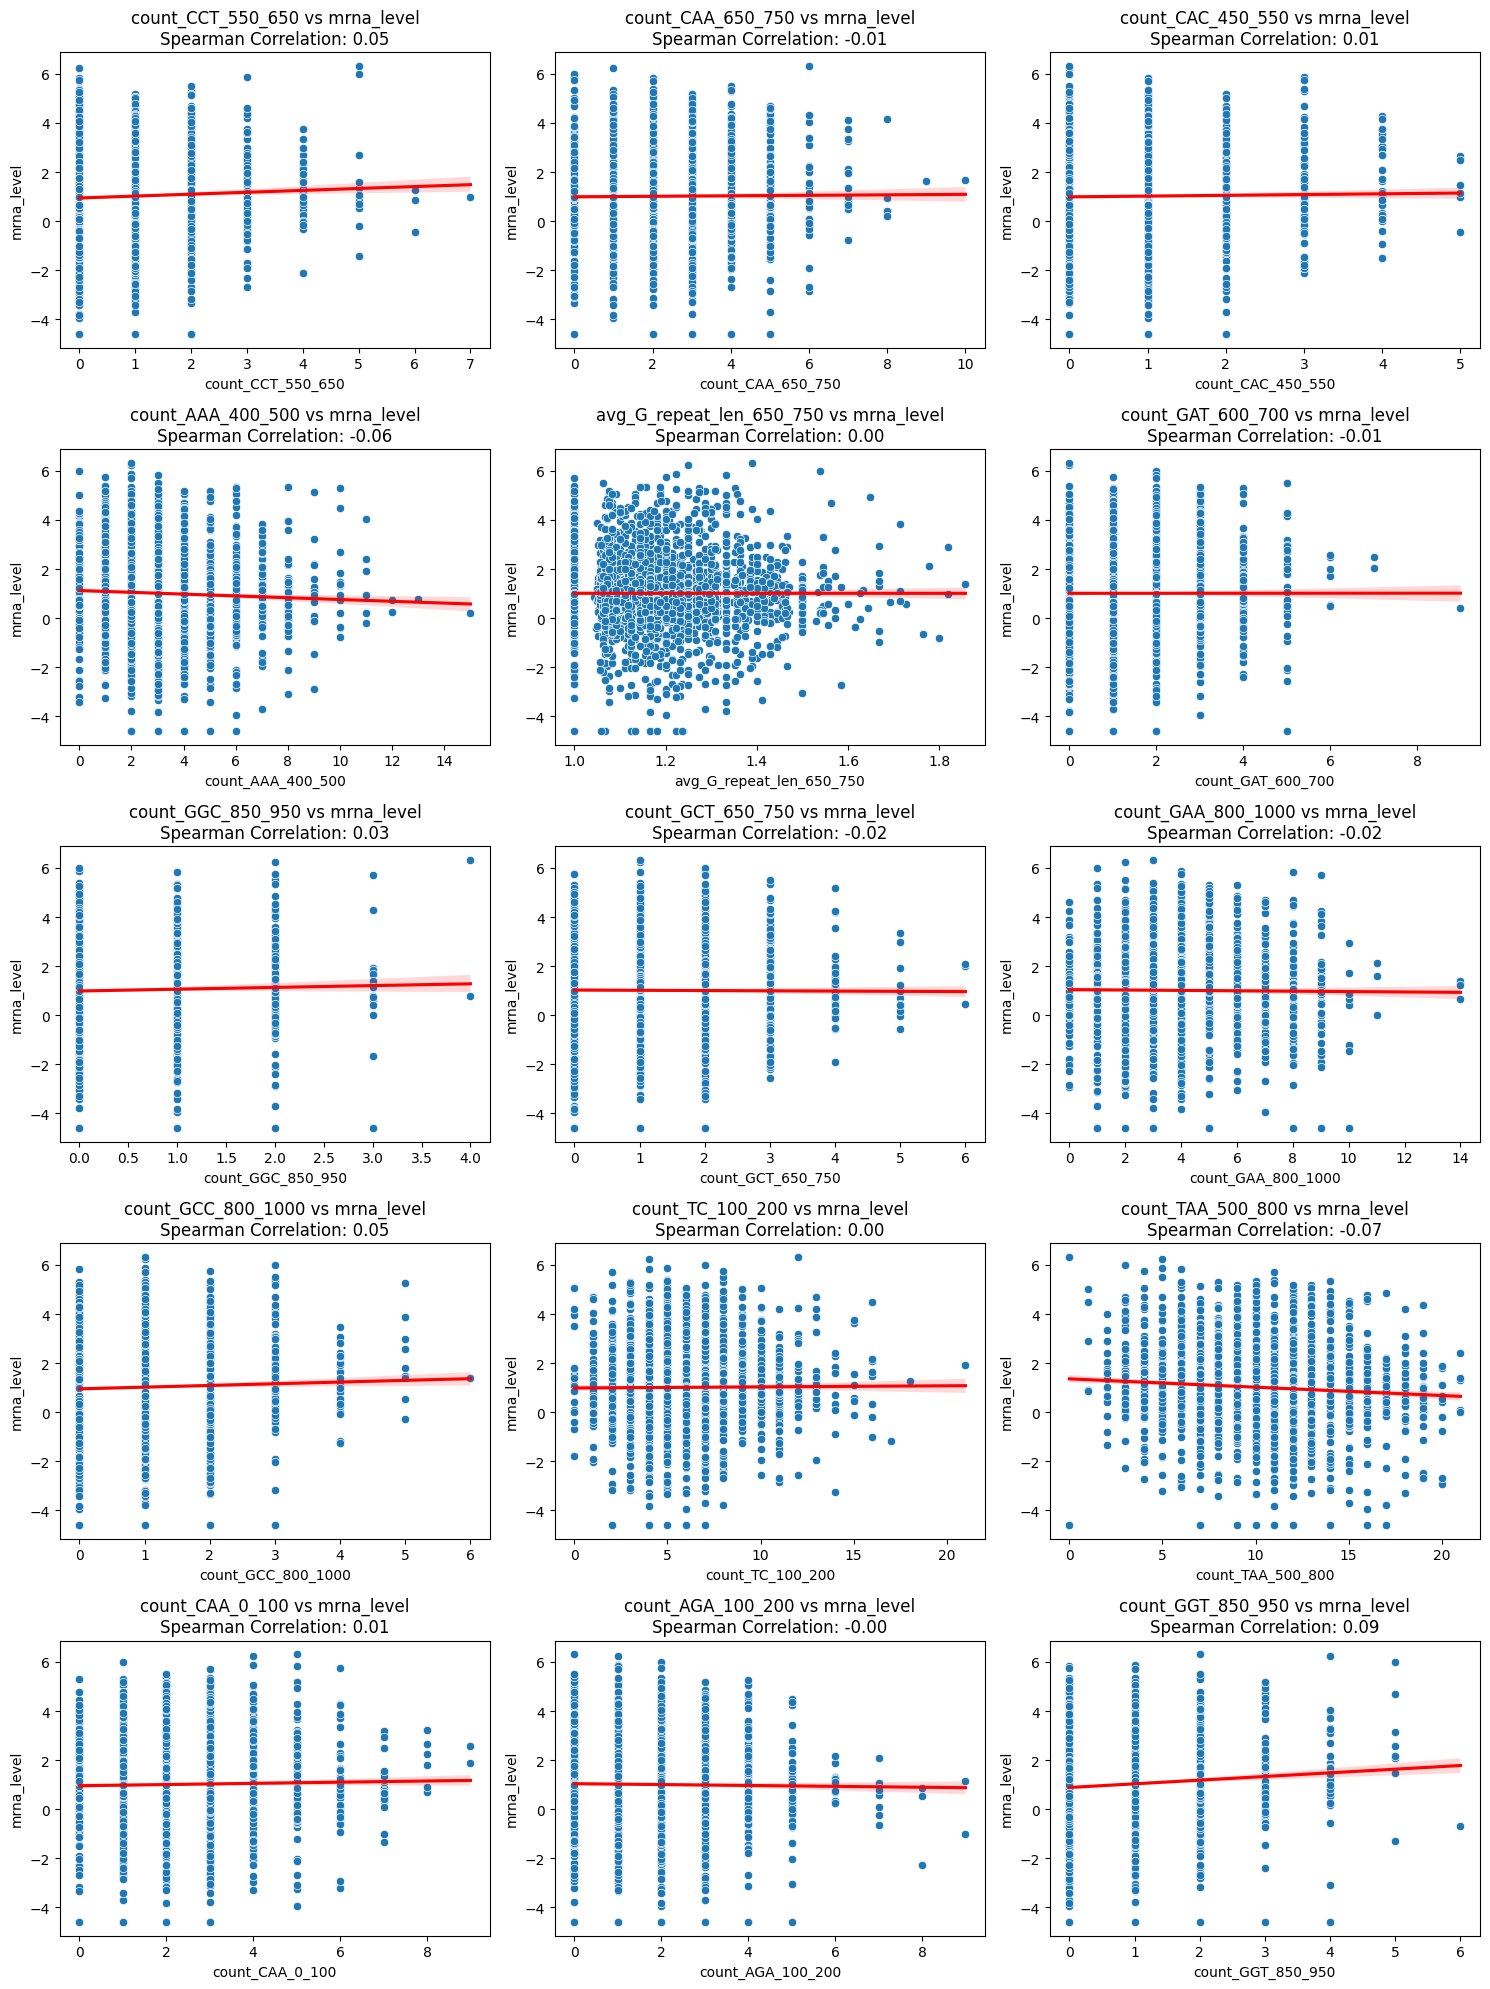

In [17]:
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

features = [col for col in df.columns if col not in ['promoter', 'mrna_level']]
random_features = random.sample(features, 15)

fig, axes = plt.subplots(5, 3, figsize=(15, 20))
axes = axes.flatten()

for i, feature in enumerate(random_features):
    sns.scatterplot(data=df, x=feature, y='mrna_level', ax=axes[i])
    # Add linear regression line
    sns.regplot(data=df, x=feature, y='mrna_level', ax=axes[i], scatter=False, color='red', line_kws={'label': 'Linear Fit'})
    # Calculate and display spearman correlation
    corr, _ = spearmanr(df[feature], df['mrna_level'])
    axes[i].set_title(f'{feature} vs mrna_level\nSpearman Correlation: {corr:.2f}')

plt.tight_layout()
plt.show()

# Plot the evolution of some k-mers over sliding windows

In [ ]:
import random as rd

random_kmers = rd.sample(dinucleotides, 3) + rd.sample(trinucleotides, 9)

for kmer in random_kmers:
    heatmap_data = []


    """THIS IS WRONG FIX THE HEATMAP"""
    for (start, end) in sliding_windows:
        # Calculate the average mRNA level for the current window
        avg_mrna_level = df['mrna_level'][(df[f'count_{kmer}_{start}_{end}'] > 0)].mean()
        heatmap_data.append({'window': f'{start}-{end}', 'avg_mrna_level': avg_mrna_level})

    # Convert to DataFrame
    heatmap_df = pd.DataFrame(heatmap_data)
    heatmap_df['window'] = pd.Categorical(heatmap_df['window'], categories=[f'{start}-{end}' for (start, end) in sliding_windows], ordered=True)
    heatmap_df = heatmap_df.sort_values('window')

    # Pivot for heatmap
    heatmap_pivot = heatmap_df.pivot(index=None, columns='window', values='avg_mrna_level')

    # Plot heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_pivot, cmap='coolwarm', annot=False, cbar_kws={'label': 'Average mRNA Level'})
    plt.title(f'Heatmap for {kmer}')
    plt.xlabel('Sliding Windows')
    plt.ylabel('Average mRNA Level')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Save results to file

In [18]:
df.to_csv(f'../data/processed/{file_name}_nt_usage_features.csv', index=False)